## Research large moves in the futures markets

In [1]:
import zipfile
import glob
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from argparse import RawDescriptionHelpFormatter
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display

import datetime
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import mibian
import py_vollib
import importlib
from py_vollib import black
from py_vollib.black import implied_volatility
import ipdb
import traceback
import pandas_datareader.data as pdr

# importlib.reload(build_db)

/Users/bperlman1/Virtualenvs3/dashrisk4/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# import warnings
# warnings.filterwarnings("ignore")

### important global variables

In [3]:

DEBUG_IT=False
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'


In [4]:
def plotly_plot(df_in,x_column,plot_title=None,
                y_left_label=None,y_right_label=None,
                bar_plot=False,figsize=(16,10),
                number_of_ticks_display=20,
                yaxis2_cols=None,
                x_value_labels=None):
    ya2c = [] if yaxis2_cols is None else yaxis2_cols
    ycols = [c for c in df_in.columns.values if c != x_column]
    # create tdvals, which will have x axis labels
    td = list(df_in[x_column]) 
    nt = len(df_in)-1 if number_of_ticks_display > len(df_in) else number_of_ticks_display
    spacing = len(td)//nt
    tdvals = td[::spacing]
    tdtext = tdvals
    if x_value_labels is not None:
        tdtext = [x_value_labels[i] for i in tdvals]
    
    # create data for graph
    data = []
    # iterate through all ycols to append to data that gets passed to go.Figure
    for ycol in ycols:
        if bar_plot:
            b = go.Bar(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        else:
            b = go.Scatter(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        data.append(b)

    # create a layout
    layout = go.Layout(
        title=plot_title,
        xaxis=dict(
            ticktext=tdtext,
            tickvals=tdvals,
            tickangle=45,
            type='category'),
        yaxis=dict(
            title='y main' if y_left_label is None else y_left_label
        ),
        yaxis2=dict(
            title='y alt' if y_right_label is None else y_right_label,
            overlaying='y',
            side='right'),
        margin=Margin(
            b=100
        )        
    )

    fig = go.Figure(data=data,layout=layout)
    fig.update_layout(
        title={
            'text': plot_title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    return fig

def plotly_shaded_rectangles(beg_end_date_tuple_list,fig):
    ld_shapes = []
    for beg_end_date_tuple in beg_end_date_tuple_list:
        ld_beg = beg_end_date_tuple[0]
        ld_end = beg_end_date_tuple[1]
        ld_shape = dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0=ld_beg[i],
            y0=0,
            x1=ld_end[i],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
        ld_shapes.append(ld_shape)

    fig.update_layout(shapes=ld_shapes)
    return fig

#### get all contracts in the options database

In [5]:
pga = db_info.get_db_info()
print(f"futtab max date: {pga.get_sql(f'select max(settle_date) from {futtab}')}")
print(f"opttab max date: {pga.get_sql(f'select max(settle_date) from {opttab}')}")


  sec_db
futtab max date:         max
0  20200306
opttab max date:         max
0  20200306


In [6]:
def get_big_bars(commod,threshold_price,threshold_perc):
    sql_big_bars = f"""
    with 
    f1 as (
        select substring(symbol,1,2) commod, symbol,settle_date,(high-low)/open hilo_perc,
        (close-open)/open open_close_perc
        from {futtab} 
        where symbol like '{commod}%%' and open_interest>0 and volume>0 and open > {threshold_price}
    ),
    f2 as (
        select commod, symbol, max(hilo_perc) hilo_perc_max from f1
        group by commod,symbol
    ),
    f3 as (
        select f1.symbol, f1.settle_date, f1.hilo_perc from f1
        join f2 on f1.symbol=f2.symbol
    )
    select * from f3 where hilo_perc >= {threshold_perc}
    order by hilo_perc desc
    """
    df_big_bars = pga.get_sql(sql_big_bars)
    return df_big_bars

In [7]:
commod = 'CL'
minprice = 20
hilo = .08
df_big_bars = get_big_bars(commod,minprice,hilo)

Distribution of CL days where (High - Low)/Open >= 0.08 and open>=20
Total days = 220


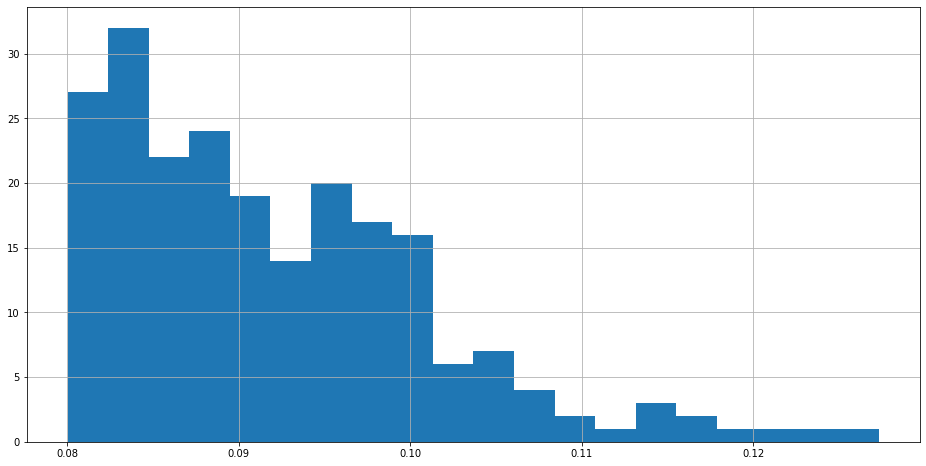

In [8]:
df_big_bars.hilo_perc.hist(bins=20,figsize=(16,8))
print(f"Distribution of {commod} days where (High - Low)/Open >= {hilo} and open>={minprice}")
print(f"Total days = {len(df_big_bars)}")

In [9]:
dfgbb = df_big_bars.sort_values('settle_date')
dfgbb.index = list(range(len(dfgbb)))
dfgbb['num'] = dfgbb.index
iplot(plotly_plot(df_in=dfgbb[['num','hilo_perc']],
                  x_column='num',bar_plot=True,
                  plot_title=f'{commod} (high-low)/open >= {hilo} and open >= {minprice}',
                  x_value_labels=dfgbb.settle_date.values))


In [10]:
 def get_large_perc_changes(commod,threshold_price,threshold_perc):
    sql_large_perc_changes = f"""
    with 
    f1 as (
        select symbol,
    --    substring(symbol,1,2) commod,
        concat(substring(symbol,1,2),
        substring(symbol,4,2),
        substring(symbol,3,1)) sym,
        settle_date,open,high,low,close,
        (close-open)/open open_close_perc
        from {futtab} 
        where symbol like '{commod}%%' and open_interest>0 and volume>0 and open > {threshold_price}
        and (close-open)/open <= {threshold_perc}
    ),
    f2 as (
        select  settle_date,min(sym) sym
        from f1
        group by settle_date
    )
    select f1.sym,f1.settle_date,open,high,low,close,f1.open_close_perc
    from f1
    join f2 on f1.sym = f2.sym and f1.settle_date = f2.settle_date
    order by f1.settle_date 
    """
    df_large_perc_changes = pga.get_sql(sql_large_perc_changes)
    return df_large_perc_changes


In [11]:
df_large_pct_chgs = get_large_perc_changes('CL',20,-.07)
display.display(df_large_pct_chgs)
df_large_pct_chgs = get_large_perc_changes('SI',10,-.07)
display.display(df_large_pct_chgs)

,sym,settle_date,open,high,low,close,open_close_perc
0,CL11M,20110505,108.78,109.38,98.25,99.80,-0.082552
1,CL15F,20141128,72.70,73.56,65.69,66.15,-0.090096
2,CL16H,20160209,30.17,30.61,27.74,27.94,-0.073914
3,CL19F,20181123,54.66,54.82,50.15,50.42,-0.077570
4,CL19N,20181224,47.72,47.72,44.20,44.27,-0.072297
5,CL20J,20200306,46.09,46.38,41.05,41.28,-0.104361


,sym,settle_date,open,high,low,close,open_close_perc
0,SI11K,20110505,39.215,39.520,34.440,36.231,-0.076093
1,SI11K,20110511,38.830,39.380,35.025,35.509,-0.085527
2,SI11V,20110824,42.140,42.290,39.178,39.178,-0.070290
3,SI11U,20110922,39.620,39.620,35.550,36.538,-0.077789
4,SI11U,20110923,36.470,36.530,30.051,30.051,-0.176008
5,SI12K,20110928,32.900,32.900,30.010,30.188,-0.082432
6,SI12F,20111117,33.965,33.965,31.325,31.521,-0.071956
7,SI13K,20130415,25.940,26.045,22.515,23.361,-0.099422
8,SI16X,20161111,18.705,18.800,17.335,17.364,-0.071692
9,SI20H,20200228,17.690,17.805,16.340,16.387,-0.073657


In [12]:
len(df_large_pct_chgs)

10

## END